In [1]:
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, models, optimizers



dataset_path = Path("D:/dataset/faces")          
DATASET_DIR = Path("D:/dataset/cropped_faces")     
BASE_SPLIT_DIR = Path("D:/dataset/split_data")
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

C:\Users\milha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
def extract_faces():
    if not dataset_path.exists():
        print(f"Skipping extraction: {dataset_path} not found.")
        return

    DATASET_DIR.mkdir(parents=True, exist_ok=True)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    total_saved = 0
    person_dirs = sorted([p for p in dataset_path.iterdir() if p.is_dir()])
    
    print("Starting face extraction...")
    for person_dir in person_dirs:
        out_person = DATASET_DIR / person_dir.name
        out_person.mkdir(parents=True, exist_ok=True)

        for img_path in person_dir.rglob("*"):
            if img_path.suffix.lower() not in [".jpg", ".jpeg"]: continue
            img = cv2.imread(str(img_path))
            if img is None: continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(80, 80))

            if len(faces) == 0: continue
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face = cv2.resize(img[y:y+h, x:x+w], IMG_SIZE)

            cv2.imwrite(str(out_person / f"{img_path.stem}_face.jpg"), face)
            total_saved += 1
    print(f"Done. Saved {total_saved} faces.")

extract_faces()

In [9]:
def prepare_splits():
    if BASE_SPLIT_DIR.exists(): shutil.rmtree(BASE_SPLIT_DIR)
    classes = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
    
    for cls in classes:
        images = list((DATASET_DIR / cls).glob("*"))
        if len(images) < 2: continue
        
        train, temp = train_test_split(images, test_size=0.30, random_state=42)
        val, test = train_test_split(temp, test_size=0.50, random_state=42)
        
        for name, set_data in [("train", train), ("val", val), ("test", test)]:
            target_path = BASE_SPLIT_DIR / name / cls
            target_path.mkdir(parents=True, exist_ok=True)
            for img_p in set_data: shutil.copy(img_p, target_path / img_p.name)
    
    print(f"Dataset split successfully into {BASE_SPLIT_DIR}")
    return classes

class_names = prepare_splits()
NUM_CLASSES = len(class_names)

Dataset split successfully into D:\dataset\split_data


In [4]:
# Data Loading
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use ResNet specific scaling
    rotation_range=15,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    BASE_SPLIT_DIR/"train", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical')

val_data = val_gen.flow_from_directory(
    BASE_SPLIT_DIR/"val", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical')

test_data = val_gen.flow_from_directory(
    BASE_SPLIT_DIR / "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  
)

# # Model Setup
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False # Start frozen

# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(), # Stabilizes training
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])
# model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Found 205 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


Found 45 images belonging to 3 classes.


In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=5)

# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=20,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
#     ]
# )

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 434ms/step - accuracy: 0.5366 - loss: 1.1404 - val_accuracy: 0.8182 - val_loss: 0.5993
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.8049 - loss: 0.5007 - val_accuracy: 0.8864 - val_loss: 0.3878
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.8585 - loss: 0.3440 - val_accuracy: 0.8636 - val_loss: 0.3608
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9268 - loss: 0.2445 - val_accuracy: 0.9318 - val_loss: 0.2034
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9317 - loss: 0.1899 - val_accuracy: 0.9318 - val_loss: 0.2205


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)

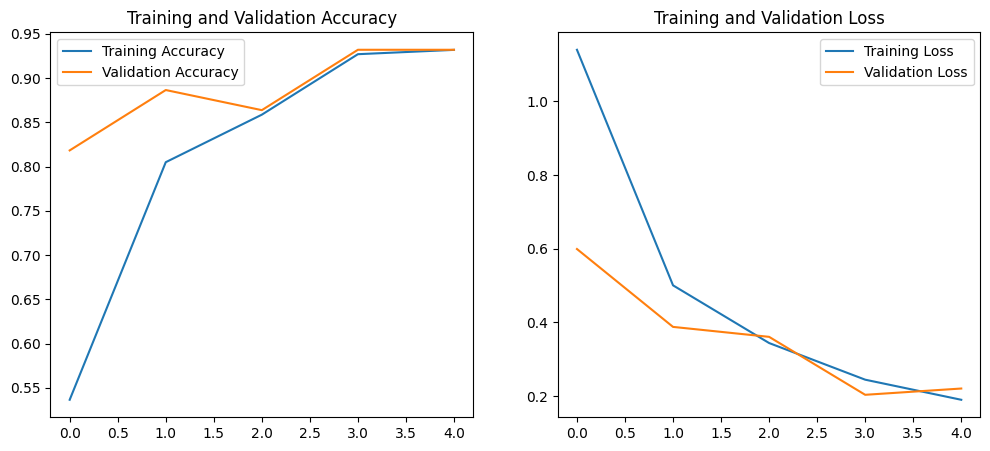

In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

Generating predictions for test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step

Classification Report:
              precision    recall  f1-score   support

       Jabir       0.88      1.00      0.94        15
      Safwan       1.00      1.00      1.00        15
    Souhardo       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



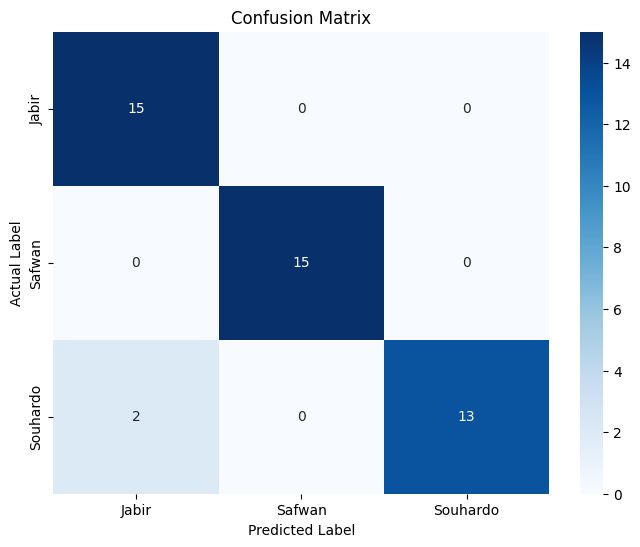

In [14]:
def evaluate_model(model, test_data, class_names):
    # 1. Get predictions
    print("Generating predictions for test set...")
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes
    
    # 2. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run evaluation
evaluate_model(model, test_data, class_names)

In [ ]:
def run_realtime_recognition(model, class_names):
    # Load face cascade for detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # Open Webcam
    cap = cv2.VideoCapture(0)
    print("Starting Webcam... Press 'q' to exit.")

    while True:
        ret, frame = cap.read()
        if not ret: break

        frame = cv2.flip(frame, 1)

        # Convert to grayscale for detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))

        for (x, y, w, h) in faces:
            # Extract and preprocess the face
            face_roi = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face_roi, (224, 224))
            
            # Convert to array and add batch dimension
            img_array = tf.keras.preprocessing.image.img_to_array(face_resized)
            img_array = np.expand_dims(img_array, axis=0)
            
            # Use the same preprocessing used in Training
            img_preprocessed = preprocess_input(img_array)

            # Prediction
            preds = model.predict(img_preprocessed, verbose=0)
            class_idx = np.argmax(preds)
            confidence = preds[0][class_idx]
            label = class_names[class_idx]

            # Visualization
            color = (0, 255, 0) if confidence > 0.7 else (0, 0, 255)
            text = f"{label} ({confidence*100:.1f}%)"
            
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        cv2.imshow('Face Recognition', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Start recognition
run_realtime_recognition(model, class_names)

Starting Webcam... Press 'q' to exit.
